## Credit Card Fraud Detection

### Introduction

The volume of credit card transactions has increased significantly in the recent years. This increase in number of transactions has also seen an increase in the number of fraudulent transactions. Although the percentage of fraudulent transactions is low, the losses incurred by merchants and banks owing to these transactions is significantly high. 

Typically, fraudulent transactions are carried out in a card not present scenario, such as mail order or online transactions, wherein a transaction can be carried out by simply using the card details. Card details can be procured through multiple ways - through card theft, through hacking databases, or by stealing the card details. Card theft and hacking of database are somewhat unlikely methods as they involve a greater amount of risk and sophistication. However stealing of card details is relatively easy. Sometimes the criminal is simply the clerk who is handling the transaction.  

### Credit Card Fraud detection using Logistic Regression

In this notebook we will attempt to detect fraudulent transactions using a logistic model. The dataset that we will use for this purpose contains transactions made by credit cards in the September of 2013 by European card holders. The dataset has an event rate of 0.17%. Fraud transactions are referred to as events in this use case. 

#### 1.1 Data description

The dataset contains 28 feature variables, all of which are numerical and have been reduced to their current form using Principal Component Analysis. Of the 284,807 transactions, only 492 transactions are fraudulent. The feature variables are named V1 to V28. The 'Class' variable is the response variable and takes value 1 in case of a fraud and 0 in case of a legitimate transaction. The dataset is available [here](https://www.kaggle.com/dalpozz/creditcardfraud/downloads/creditcardfraud.zip) for download. 

#### 1.2 Data Preprocessing

As the event rate is low, the dataset is imbalanced and hence one of the steps in data preprocessing is to create a balanced dataset. We'll do this using oversampling of the events. Apart from that we'll do checks for missing values, outliers and multicollinearity as well. 

##### 1.2.1 Missing value treatment

In [1]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [2]:
# dimensions of the dataset
print('Data dimensions: ', df.shape, '\n')

# column names
print('Column names: ', df.columns, '\n')

# event rate
print('Event rate: ',sum(df.loc[:, 'Class'])/df.shape[0], '\n')

# Number of missing values in each column
print('Number of missing values in each column \n', df.isnull().sum(axis=0))

Data dimensions:  (284807, 31) 

Column names:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object') 

Event rate:  0.00172748563062 

Number of missing values in each column 
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


There are no missing values in the dataset. We will drop the column from our dataset as it indicates the times elapsed since the first transaction and is not useful for card fraud detection. In the next section we'll check for outliers.

In [3]:
df.drop(['Time'],axis=1,inplace=True)
print(df.shape)
print(df.columns)

(284807, 30)
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')


##### 1.2.2 Outlier treatment

We will look for outliers for all columns using the zscores for every entry in a column. It is possible that events may get excluded after dropping outliers. In case the number of events drop by more than 10 percent, we'll not drop the outliers

In [4]:
from scipy import stats
import numpy as np
print('Number of records without outliers: ', (np.abs(stats.zscore(df)) < 3).all(axis=1).sum(axis=0))

Number of records without outliers:  246943


In [5]:
# drop records with outliers 
df_otlr = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

# get dimensions of the new dataset
print('Dimensions of dataset after excluding outliers:', df_otlr.shape, '\n')

# calculate event rate after dropping outliers
print('Number of events: ',sum(df_otlr.loc[:, 'Class']), '\n')


Dimensions of dataset after excluding outliers: (246943, 30) 

Number of events:  0 



As the number of events are dropped to zero on removing outliers, we'll not be dropping the outliers. 

##### 1.2.3 Remove duplicates

We'll drop the duplicated rows and check the event rate

In [6]:
# get number of duplicated rows
print('Number of duplicated rows: ', df.duplicated().sum())

# get number of events on exlcuding duplicates
print('Events after excluding dupes: ', df.loc[~df.duplicated(),'Class'].sum())

# decrease in number of events
print('Decrease in events after excluding dupes: ', df.loc[:,'Class'].sum()- df.loc[~df.duplicated(),'Class'].sum())

df = df.loc[~df.duplicated(),:]
print('Dimensions after dropping dupes: ', df.shape)

Number of duplicated rows:  9144
Events after excluding dupes:  473
Decrease in events after excluding dupes:  19
Dimensions after dropping dupes:  (275663, 30)


There is a decrease of 19 events on dropping the duplicate rows. We'll tackle this issue in the next section by balancing the dataset using oversampling.

##### 1.2.4 Balancing the dataset

There are two ways we can go about to balance the dataset - undersampling and over sampling. In undersampling we select a only certain number of instances from the majority class to create a balanced dataset, whereas in oversampling we can either generate synthetic instances of the minority dataset or duplicate them to create a balanced dataset. We will balance the dataset using oversampling because in undersampling there is a loss of information involved.

We will use oversampling to synthetically increase the event rate in the dataset. Oversampling can be done by using -
(i) *random oversampling*, 
(ii) *synthetic minority oversampling technique (SMOTE)* or through 
(iii) *Adaptive Synthetic (ADASYN)* sampling

###### Random oversampling

Random oversampling is the most naive approach wherein we duplicate instances from the minority class to create a balanced dataset. However, the model fitted on the balanced dataset resulting from this method of balancing is prone to overfitting as it replicates the minority class events. 

###### Synthetic Minority Oversampling Technique (SMOTE) 

Both SMOTE and ADASYN aim to reduce the likelihood of overfitting as is the case with random oversampling by generating synthetic instances of the minority class. In these methods, a subset of the data from the minority class is selected and new samples are generated considering its k nearest neighbors. For example, consider a sample $x_i$. A new sample - $x_{new}$ will be generated using the nearest neighbors of $x_i$. We'll consider 3 nearest neighbors for this example. Then, one of these nearest-neighbors $x_{zi}$ is selected and a sample is generated using the following equation - 
$$x_{new} = x_i + \lambda * (x_{zi} - x_i)$$

<img src="smote_adasyn_example.png" alt="smote/adasyn use nearest neighbors to generate synthetic samples of the minority class" style="height: 400px;" title= 'smote/adasyn use nearest neighbors to generate synthetic samples of the minority class'/>

SMOTE and ADASYN differ in the way they select the samples $x_i$.

SMOTE has a few variants. The regular SMOTE, described above, doesn't take into consideration the data distribution of the minority classes and the latent noises in the dataset. The modified SMOTE classifies each sample $x_i$ into either of three classes - noise sample, borderline sample or safe sample. A sample $x_i$ will be classified- as noise if all nearest-neighbors are from a different class than the one of $x_i$; as borderline/danger if at least half of the nearest neighbors are from the same class than $x_i$, or as safe if all nearest neighbors are from the same class as that of $x_i$

ADASYN works similar to the regular SMOTE. However, the number of samples generated for each $x_i$ is proportional to the number of samples which are not from the same class as $x_i$ in a given neighborhood. 

###### ADASYN Algorithm

We will go through the input to the ADASYN algorithm and the steps involved in this section.

The input to the ADASYN algorithm is the training dataset $D_{tr}$ with $m$ samples ${x_i, y_i}$, where $i$  $\epsilon $ ${[1,m]}$. Here $x_i$ is an instance in the $n$ dimensional feature space $X$ and $y_i$ $\epsilon$  $Y = {[1, −1]}$ is the class identity label associated with $x_i$. Define $m_s$ and $m_l$ as the number of minority class examples and the number of majority class examples, respectively. Therefore, $m_s ≤ ml$ and $m_s + m_l = m$.

**Step 1** 

We first calculate the degree of imbalance which is defined by 
$$d = m_s/m_l$$ where $d$ $\epsilon$ $(0,1]$

In case $d$ is less than $d_{th}$ where $d_{th}$ is a preset threshold for the maximum tolerated degree of class imbalance ratio, we calculate the number of synthetic examples that we need to generate for the minority class using the below equation
$$G = (m_l-m_s)*\beta$$ 

Here $\beta$ $\epsilon$ $(0,1]$ is a parameter used to specify the desired balance level after generation of the synthetic data. $\beta = 1$ means a fully balanced data set is created after the generalization process. 

**Step 2**

For each sample $x_i$ $\epsilon$ in the minorityclass, we find the $K$ nearest neighbors based on the Euclidean distance in $n$ the dimensional space of the data, and calculate a ratio called $r_i$ which is defined as:
$$r_i = \Delta_{i}/K$$ where  $i = 1, ..., m_s$
where $\Delta_{i}$ is the number of examples in the K nearest neighbors of $x_i$ that belong to the majority class, therefore $r_i$ $\epsilon$ $[0, 1]$

**Step 3**

Normalize $r_i$ according to 

$$\hat r_i = r_i/\sum_{i=1}^{m_s} r_i $$

so that $\hat r_i$ is a density distribution 

**Step 4** 

For each sample $x_i$ we calculate the number of synthetic data examples that need to be generated from it using-
$$g_i = \hat r_i × G$$
where $G$ is the total number of synthetic data examples that need to be generated for the minority class as defined in step 2.

**Step 5**

For each minority class data example $x_i$, we generate $g_i$ synthetic data examples according to the following steps:

*Do Loop* from $1$ to $g_i$:

(i) Randomly choose one minority data example, $x_{zi}$, from the $K$ nearest neighbors for data $x_i$.

(ii) Generate the synthetic data example:
    $s_i = x_i + (x_{zi} − x_i) * \lambda $
where $(x_{zi} − x_i)$ is the difference vector in $n$ dimensional space, and $\lambda$ is a random number: $\lambda$  $\epsilon$ [0, 1].

*End Loop*

The complete description for the alogrithm can be found [here](http://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf)

We will be using the ADASYN method to balance our dataset. 

In [7]:
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN().fit_sample(df.iloc[:,0:29], df.loc[:,'Class'])

In [8]:
# check event rate
print('Event rate after data balancing: ', round(100*sum(y_resampled)/y_resampled.shape[0], 1))

Event rate after data balancing:  50.0


In [9]:
# store in a dataframe
df_blncd = pd.DataFrame(X_resampled)
df_blncd.loc[:,'Class'] = y_resampled
df_blncd.columns = df.columns
# save as csv
df_blncd.to_csv('creditcard_blncd.csv', index=False)

In [10]:
# load the dataset
import pandas as pd
import numpy as np
df_blncd = pd.read_csv('creditcard_blncd.csv')

In [11]:
# dimensions
print(df_blncd.shape)
print(df_blncd.columns)

(550343, 30)
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')


##### 1.2.5 Split into test and train dataset

We will split the dataset in two parts - train and test. We will train the model on the train dataset and check the accuracy metrics on the test dataset. The train dataset will contain seventy percent of the records, remaining will be the test dataset. We will use stratified random sampling for this. 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
srsampler = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [13]:
indices = srsampler.split(df_blncd.iloc[:,0:29].values, df_blncd.iloc[:,29].values)
indices = list(indices)
train_indices = indices[0][0]
test_indices = indices[0][1]
print('Number of records in train dataset: ', len(train_indices))
print('Number of records in test dataset: ', len(test_indices))

Number of records in train dataset:  385240
Number of records in test dataset:  165103


In [14]:
# display five random rows
df_blncd.iloc[np.random.choice(df_blncd.shape[0],5),:]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
259127,-0.523601,-0.106404,1.023319,-1.765248,0.000603,0.325537,0.068207,0.186511,-1.046466,0.300553,...,-0.211181,-0.075838,-0.156380,-1.027632,-0.147613,0.677933,0.326476,0.187296,56.000000,0
536075,1.758032,0.041389,-2.133306,0.096592,0.589092,-1.044279,0.413773,-0.309613,-0.116252,-0.444553,...,0.285859,0.840293,-0.250059,0.222577,0.713567,-0.155384,-0.011522,-0.004803,56.931406,1
420339,-1.141798,0.898709,1.490218,0.413025,-0.355255,0.069526,0.614395,-0.278422,0.818906,0.694853,...,-0.017249,0.774304,-0.141222,0.139093,-0.194788,0.484854,0.210018,0.207010,69.017255,1
27647,0.963559,-0.140498,0.245779,1.362385,-0.528540,-0.841517,0.271008,-0.197613,0.070831,0.020184,...,0.147275,0.124679,-0.224035,0.390920,0.599972,-0.293738,-0.012529,0.045022,144.000000,0
70532,-1.949554,0.696984,1.997286,0.876533,-0.570011,0.433954,0.085741,0.120816,1.164050,1.402840,...,-0.069561,0.567322,-0.384765,-0.470380,0.499177,0.011329,0.571843,0.529597,100.000000,0


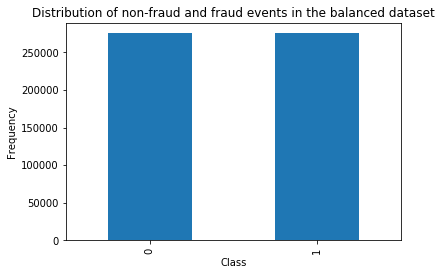

In [15]:
import matplotlib.pyplot as plt
pd.value_counts(df_blncd['Class']).plot.bar()
plt.title('Distribution of non-fraud and fraud events in the balanced dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
df_blncd['Class'].value_counts()
plt.show()

###### 1.2.6 Normalize the amount 

We will normalize the amount column to make the model independent of the unit in which the amount is represented. We will also drop the the Time from our model building.

In [16]:
from sklearn.preprocessing import StandardScaler
df_blncd['normAmount'] = StandardScaler().fit_transform(df_blncd['Amount'].values.reshape(-1, 1))
df_blncd.drop(['Amount'], axis=1,inplace=True)
print(df_blncd.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'normAmount'],
      dtype='object')


In [17]:
reorder_cols = list(range(28))+[29,28]
df_blncd = df_blncd.iloc[:,reorder_cols]
df_blncd.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,normAmount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.085748,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.485467,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.976178,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,-0.015798,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.223827,0


In [18]:
df_train = df_blncd.iloc[train_indices,:]
df_test = df_blncd.iloc[test_indices,:]
print(df_train.shape)
print(df_test.shape)

(385240, 30)
(165103, 30)


#### 2. Logistic Regression

##### 2.1 Building a logistic model

We will build a logistic model in this section and assess its performance. Since the number of features in our dataset are not too many we will use L2 regularization for our models. We will train our model on `df_train` and calculate the model statistics on the `df_test` dataset.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [20]:
# instantiate the model
log_clf = LogisticRegression(penalty='l2', dual=False, tol=0.01, C=10, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, 
                        solver='liblinear', max_iter=100, multi_class='ovr', 
                        verbose=0, warm_start=False, n_jobs=1)

In [21]:
# fit the model
log_clf.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

In [22]:
# predictions
predictions_lr = log_clf.predict(df_test.iloc[:,0:29])

# get classification report
target_names=['Legitmate', 'Fraud']
print(classification_report(df_test.loc[:,'Class'], predictions_lr, target_names=target_names))

             precision    recall  f1-score   support

  Legitmate       0.79      0.90      0.84     82557
      Fraud       0.88      0.77      0.82     82546

avg / total       0.84      0.83      0.83    165103



##### 2.2 Parameter Tuning 

In [23]:
# make predictions on the test dataset
param_grid = {
    'C': np.linspace(0.01, 10, 10)
             }
lr = LogisticRegression()
lr_clf_grd = GridSearchCV(lr, param_grid, cv=2, verbose=5, n_jobs=3)
lr_clf_grd.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])
print(clf.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=1.12 ..........................................................
[CV] C=1.12 ..........................................................
[CV] C=2.23 ..........................................................
[CV] C=2.23 ..........................................................


Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

We will create a model using the `C` from the above results.

In [24]:
# instantiate the model
log_clf = LogisticRegression(penalty='l2', dual=False, tol=0.01, C=2.23, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, 
                        solver='liblinear', max_iter=100, multi_class='ovr', 
                        verbose=0, warm_start=False, n_jobs=1)

# fit the model
log_clf.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

# predictions
predictions_lr = log_clf.predict(df_test.iloc[:,0:29])

##### 2.3 Classification Report

In [25]:
# get classification report
target_names=['Legitmate', 'Fraud']
print(classification_report(df_test.loc[:,'Class'], predictions_lr, target_names=target_names))

             precision    recall  f1-score   support

  Legitmate       0.79      0.90      0.84     82557
      Fraud       0.88      0.77      0.82     82546

avg / total       0.84      0.83      0.83    165103



In [26]:
# function to plot confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

##### 2.4 Confusion matrix and ROC AUC curve

AUC ROC:  0.921867240549


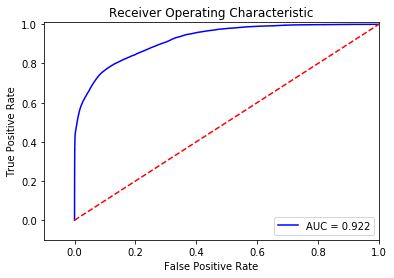

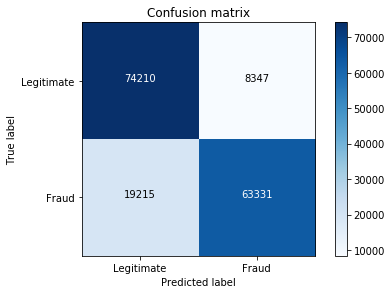

In [28]:
# plot the confusion matrix
cnf_matrix_lr = confusion_matrix(df_test.loc[:,'Class'], predictions_lr)
class_names = ['Legitimate','Fraud']

# plot the AUC ROC curve
y_pred_score_log = log_clf.decision_function(df_test.iloc[:,0:29])
fpr_log, tpr_log, thresholds = roc_curve(df_test.loc[:,'Class'], y_pred_score_log)
roc_auc_log = auc(fpr_log,tpr_log)
print('AUC ROC: ',roc_auc_log)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log, tpr_log, 'b',label='AUC = %0.3f'% roc_auc_log)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, title='Confusion matrix')

#### 3. Random Forest

We will be building a random forest model in this section. In parameter tuning we will tune the foloowing parameters - `n_estimators`, `min_samples_split`, `min_samples_leaf`

##### 3.1 Fitting a random forest model

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                                random_state=42, verbose=0, warm_start=False, class_weight=None)

In [30]:
# fit the model
rf_clf.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
# predictions
predictions_rf = rf_clf.predict(df_test.iloc[:,0:29])

# get classification report
target_names=['Legitmate', 'Fraud']
print(classification_report(df_test.loc[:,'Class'], predictions_rf, target_names=target_names))

             precision    recall  f1-score   support

  Legitmate       1.00      1.00      1.00     82557
      Fraud       1.00      1.00      1.00     82546

avg / total       1.00      1.00      1.00    165103



##### 3.2 Parameter Tuning 

In [ ]:
param_grid = {"n_estimators": [int(i) for i in np.arange(10, 1000, 200)],
              "max_depth": [int(i) for i in np.arange(2, 30, 10)],
              "min_samples_split": [int(i) for i in np.arange(2,150,25)],
              "min_samples_leaf": [int(i) for i in np.arange(2,60,15)],
              "max_leaf_nodes": [int(i) for i in np.arange(2,60,15)],
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.15)}

rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                                random_state=42, verbose=0, warm_start=False, class_weight=None)

rf_clf_grd = GridSearchCV(rf, param_grid, cv=2, verbose=5, n_jobs=3)

rf_clf_grd.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])
print(rf_clf_grd.best_params_)

Fitting 2 folds for each of 4320 candidates, totalling 8640 fits
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=10 
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=10 
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7470005866442392, total=   1.4s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7472367731116868, total=   1.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, 

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.3min


[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413339286363235, total=  25.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7515665640461221, total= 1.9min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=410, score=0.7448720544488918, total=  51.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7499130416725072, total= 1.9min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413443118280129, total=  26.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7515665640461221, total= 1.8min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estima

[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 17.6min


[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7511849694477757, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7525737336399836, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7415961914848329, total=   1.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimator

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7497261461626717, total=  57.2s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.750907231373852, total=  53.8s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7511849694477757, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7496716315628261, total=  26.3s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7566491363780312, total=  57.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7497313377046116, total=  49.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_esti

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7552759044963945, total=  59.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7492381412203238, total=  28.3s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7496456735836029, total=  27.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.4, n_est

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 40.2min


[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7511797779058358, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7525685420441389, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7417000223236303, total=   1.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_es

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7497313377046116, total=  51.7s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.750907231373852, total=  52.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7511849694477757, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7496612483711368, total=  28.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7566491363780312, total= 1.0min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7497313377046116, total=  52.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.1, n_esti

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7552655214125147, total=  58.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7492329496783839, total=  27.2s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7496508651794475, total=  26.4s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=27, min_weight_fraction_leaf=0.4, n_est

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7468707980957424, total=   1.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7472834974742886, total=   2.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7552862875802742, total=  57.7s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estima

[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 98.4min


[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413443118280129, total=  23.8s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7515665640461221, total= 1.7min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=410, score=0.7448824375327716, total=  45.3s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=77, min_weight_fraction_leaf=0.25,

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7412898905103805, total=  24.3s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7499130416725072, total= 1.7min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413443118280129, total=  23.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=102, min_weight_fraction_lea

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7415858084009531, total=   2.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.741474101724129, total=   1.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413158482200799, total=  23.8s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=17, min_samples_split=127, min_weight_fraction_leaf=0.2

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7511849694477757, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7525685420441389, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7415961914848329, total=   2.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7497313377046116, total=  52.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.750907231373852, total=  51.2s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7511797779058358, total= 1.3min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estim

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7496664399669815, total=  26.6s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=27, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7566439447821866, total=  58.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7497261461626717, total=  51.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.1, n_esti

[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 150.6min


[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=410, score=0.7572617446876996, total=  33.3s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=810, score=0.752890420986507, total= 1.6min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=610, score=0.7563609367618276, total=  45.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=52, min_weight_fraction_leaf=0.4, n_est

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=210, score=0.7558340558304217, total=  16.2s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=410, score=0.7562311482133308, total=  30.8s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=410, score=0.7572669362835442, total=  30.6s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=77, min_weight_fraction_leaf=0.25, n_es

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=210, score=0.7552032229092362, total=  16.4s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=210, score=0.7558963549805575, total=  16.3s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=810, score=0.751216118699415, total= 1.5min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=102, min_weight_fraction_leaf=0.4

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_estimators=10, score=0.7484905591809824, total=   1.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_estimators=10, score=0.7493186030453901, total=   1.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_estimators=210, score=0.7552084144511761, total=  16.1s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=32, min_samples_split=127, min_weight_fraction_leaf=0.4, n_e

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=610, score=0.7571033272592292, total= 1.1min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=610, score=0.754728245915512, total= 1.1min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.4, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.4, n_estimators=10, score=0.7484542183874032, total=   1.6s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=2, min_weight_fraction_leaf=0.4, n_estimators

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=410, score=0.7448824375327716, total=  45.8s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=410, score=0.745103027219537, total=  45.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, n_estimators=610, score=0.7570981357172893, total= 1.2min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=27, min_weight_fraction_leaf=0.25, 

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413391202321682, total=  24.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7515717556419668, total= 1.7min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.25, n_estimators=410, score=0.744866862906952, total=  47.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=52, min_weight_fraction_leaf=0.25, n

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413054651362001, total=  26.2s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7499130416725072, total= 1.9min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=410 


[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 201.6min


[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413495034238574, total=  27.6s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7515665640461221, total= 1.9min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=410, score=0.7448824375327716, total=  53.2s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=77, min_weight_fraction_leaf=0.25,

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7412795074265007, total=  29.9s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=810, score=0.7499130416725072, total= 1.9min
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.7413650782113914, total=  28.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_leaf=0.25, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=102, min_weight_fraction_lea

[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7416532984461714, total=   2.5s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7415000597033522, total=   2.4s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=210, score=0.74131065667814, total=  28.6s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=47, min_samples_split=127, min_weight_fraction_leaf=0.25

[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7911598423847868, total= 1.7min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7926268955814327, total= 1.7min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7515483773835667, total=   2.6s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.25, n_estimators

[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7914090363979005, total= 1.1min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7931304803783635, total= 1.1min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7911650339267265, total= 1.6min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.1, n_esti

[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=27, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7566491363780312, total=  54.5s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7968061302363734, total=  32.3s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=610 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_estimators=410, score=0.7914142279398404, total= 1.1min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.1, n_esti

[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7552707129544546, total=  59.5s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=210, score=0.7948821779556746, total=  38.6s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estimators=410 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=52, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.756638753186342, total=  59.0s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.1, n_estim

[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7707103586836326, total=   2.9s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7690051344882903, total=   3.3s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_estimators=210 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=77, min_weight_fraction_leaf=0.4, n_estimators=810, score=0.7552810960383344, total= 1.0min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.1, n_es

[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=610, score=0.7563661283037675, total=  42.1s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=102, min_weight_fraction_leaf=0.4, n_estimators=610, score=0.7581183580020663, total=  42.4s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=10, score=0.7707518910191516, total=   2.7s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n

[Parallel(n_jobs=3)]: Done 876 tasks      | elapsed: 308.4min


[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7911598423847868, total= 1.6min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=810 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.1, n_estimators=610, score=0.7926268955814327, total= 1.6min
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10, score=0.7516262505126647, total=   2.0s
[CV] max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.25, n_estimators=10 
[CV]  max_depth=2, max_leaf_nodes=17, min_samples_leaf=2, min_samples_split=127, min_weight_fraction_leaf=0.2

We will create a grid using the best parameters returned from the grid search

In [ ]:
# instantiate the model
rf_clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                                random_state=42, verbose=0, warm_start=False, class_weight=None)

# fit the model
rf_clf.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

# predictions
predictions_rf = rf_clf.predict(df_test.iloc[:,0:29])

##### 3.3 Classification Report

In [ ]:
# get classification report
target_names=['Legitmate', 'Fraud']
print(classification_report(df_test.loc[:,'Class'], predictions_rf, target_names=target_names))

##### 3.4 Confusion matrix and ROC AUC curve

AUC ROC:  0.999797341285


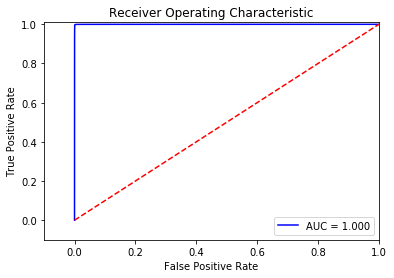

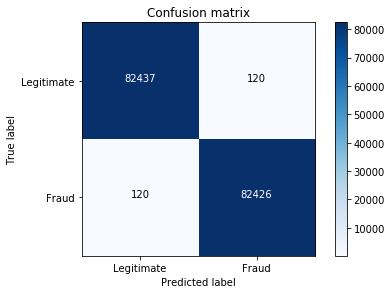

In [41]:
# plot the confusion matrix
cnf_matrix_rf = confusion_matrix(df_test.loc[:,'Class'], predictions_rf)
class_names = ['Legitimate','Fraud']

# plot the AUC ROC curve
# print(type(rf_clf.predict_proba(df_test.iloc[:,0:29])))
y_pred_score_rf = rf_clf.predict_proba(df_test.iloc[:,0:29])
fpr_rf, tpr_rf, thresholds = roc_curve(df_test.loc[:,'Class'], y_pred_score_rf[:,1])
roc_auc_rf = auc(fpr_rf,tpr_rf)
print('AUC ROC: ',roc_auc_rf)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'b',label='AUC = %0.3f'% roc_auc_rf)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, title='Confusion matrix')

#### 4. AdaBoost Classifier

##### 4.1 Fitting the model

So far we have used a logistic model and a tree based model. Logistic regression is a parametric model while random forest is a non-parametric model. Next we will train a boosted model based on a non parametric learner - k Nearest Neighbors (kNN). 

In [ ]:
# fit a knn model
knn = =NearestNeighborsClassifier(max_depth=9, min_samples_leaf=1)
knn.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

# set the parameters
n_estimators = 400
learning_rate = 1.

# train the adaboost algorithm
ada_real = AdaBoostClassifier(
    base_estimator=knn,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")

ada_real.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

##### 4.2 Classification report and predictions

In [ ]:
# predictions
predictions_ad = ada_rexsal.predict(df_test.iloc[:,0:29])

In [ ]:
# get classification report
target_names=['Legitmate', 'Fraud']
print(classification_report(df_test.loc[:,'Class'], predictions_ad, target_names=target_names))

##### 4.3 Confusion matrix and ROC AUC curve

In [ ]:
# plot the confusion matrix
cnf_matrix_ad = confusion_matrix(df_test.loc[:,'Class'], predictions_ad)
class_names = ['Legitimate','Fraud']

# plot the AUC ROC curve
# print(type(rf_clf.predict_proba(df_test.iloc[:,0:29])))
y_pred_score_ad = ad_clf.predict_proba(df_test.iloc[:,0:29])
fpr_ad, tpr_ad, thresholds = roc_curve(df_test.loc[:,'Class'], y_pred_score_ad[:,1])
roc_auc_ad = auc(fpr_ad,tpr_ad)
print('AUC ROC: ',roc_auc_ad)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_ad, tpr_ad, 'b',label='AUC = %0.3f'% roc_auc_ad)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plot_confusion_matrix(cnf_matrix_ad, classes=class_names, title='Confusion matrix')

### Parent Classification

The idea behind building the classifiers above is not only for comparing their classification metrics. The next step is to build a parent classifier which will leverage all the models built above.

<img src = 'classification_process.png'>

##### Creating the input data for the stacked model

In this section we will create the input data for the final logistic model. The input feature data to the stacked logistic model will be the predictions from each of the classifiers. The input target data will be the true data. 

In [ ]:
train_feature_array = np.asarray([lr_clf.predict(df_train.iloc[:,0:29]),
                                  rf_clf.predict(df_train.iloc[:,0:29]),
                                  ada_real.predict(df_train.iloc[:,0:29])
                                 ])

test_feature_array = np.asarray([lr_clf.predict(df_test.iloc[:,0:29]),
                                  rf_clf.predict(df_test.iloc[:,0:29]),
                                  ada_real.predict(df_test.iloc[:,0:29])
                                 ])

train_target = df_train.loc[:,'Class']
test_target = df_test.loc[:,'Class']

##### Fitting a logistic model

In [ ]:
# make predictions on the test dataset
param_grid = {
    'C': np.linspace(0.01, 10, 10)
             }
lr = LogisticRegression()
lr_clf_grd = GridSearchCV(lr, param_grid, cv=2, verbose=5, n_jobs=3)
lr_clf_grd.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])
print(lr_clf_grd.best_params_)

In [ ]:
# instantiate the model
log_clf = LogisticRegression(penalty='l2', dual=False, tol=0.01, C=2.23, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, 
                        solver='liblinear', max_iter=100, multi_class='ovr', 
                        verbose=0, warm_start=False, n_jobs=1)

# fit the model
log_clf.fit(df_train.iloc[:,0:29], df_train.loc[:,'Class'])

# predictions
predictions_lr = log_clf.predict(df_test.iloc[:,0:29])

##### Model Assessment

In [ ]:
# get classification report
target_names=['Legitmate', 'Fraud']
print(classification_report(df_test.loc[:,'Class'], predictions_lr, target_names=target_names))

In [ ]:
# plot the confusion matrix
cnf_matrix_ad = confusion_matrix(df_test.loc[:,'Class'], predictions_ad)
class_names = ['Legitimate','Fraud']

# plot the AUC ROC curve
# print(type(rf_clf.predict_proba(df_test.iloc[:,0:29])))
y_pred_score_ad = ad_clf.predict_proba(df_test.iloc[:,0:29])
fpr_ad, tpr_ad, thresholds = roc_curve(df_test.loc[:,'Class'], y_pred_score_ad[:,1])
roc_auc_ad = auc(fpr_ad,tpr_ad)
print('AUC ROC: ',roc_auc_ad)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_ad, tpr_ad, 'b',label='AUC = %0.3f'% roc_auc_ad)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plot_confusion_matrix(cnf_matrix_ad, classes=class_names, title='Confusion matrix')